In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import rasterio
from rasterio.mask import mask
import scipy.io as sio
import geopandas as gpd
import matplotlib.pyplot as plt


In [ ]:
with rasterio.open('C:\\Users\\jmt30\\Desktop\\문화재\\영상 데이터\\2023\\hyper\\02_20230616_Buso_Hyper_Subset') as src:
    print(src.read())

## tif과 shp파일를 csv파일로 변환

In [3]:
## SHP file 
shp_file_path = "F:\\문화재\\2307_Gong\\2307_Gong\\2307_hyper_akk\\"
shp_file_name = "2307_hyper_akk.shp"

## HyperSpectral Iamge file 
hsp_img_path = 'E:\\Downloads\\2307_Gong\\2307_Gong\\'
hsp_img_name = "2307_4,6,8,9,10,11,12_mnf.dat" 
hsp_img_hdr_name = "2307_4,6,8,9,10,11,12_mnf.hdr"


In [28]:
with rasterio.open('2307_4,6,8,9,10,11,12_mnf') as src:
    data=src.read()
    test= data.transpose((1,2,0))
with rasterio.open("E:\\Downloads\\2307_Gong\\2307_Gong\\2307_4,6,8,9,10,11,12_mnf.dat") as src:
    data1=src.read()
    test1= data1.transpose((1,2,0))

In [30]:
test1.shape

(2786, 2558, 100)

In [2]:
# 이미지에서 폴리곤에 해당하는 영역 마스킹
def get_masked_area(src, shapes, crop=True, invert=False):
    # 이미지에서 폴리곤에 해당하는 영역 마스킹
    out_image, out_transform = mask(src, shapes, crop=crop, invert=invert)
    return out_image

In [3]:
def trans2csv(path1,path2,gt_path,save_path):
    # 폴리곤을 GeoJSON 형태로 변환
    shp_data = gpd.read_file(path2)
    shapes = [feature["geometry"] for _, feature in shp_data.iterrows()]
    with rasterio.open(path1) as src:
        #데이터 로딩
        data1 = src.read()
        gs =data1.transpose((1,2,0))
        # 폴리곤 외부 영역 마스킹 (전체 이미지에서 폴리곤 제외)
        outside_area = get_masked_area(src, shapes, crop=False, invert=False)  # 폴리곤 외부
        gt=outside_area[1]
        gt= np.where(gt >= 1 , 1, 0)
        plt.imshow(gt)
        # plt.imshow(gt)
        # #부소산성용
        # gt[:150, :] = 0
        # gt[-150:, :] = 0

        # # 좌우 가장자리 150픽셀씩 0으로 설정
        # gt[:, :150] = 0
        # gt[:, -150:] = 0
    # gt=np.array(pd.read_csv(gt_path))    
    print(f'gs shape: {gs.shape}')
    print(f'gt shape: {gt.shape}')
    df1= pd.DataFrame(gt)
    df1.to_csv('../data/gs_2307_mnf_gt.csv',index=False)
    gs=gs.reshape(-1,100)
    gt=gt.reshape(-1)
    df = pd.DataFrame(gs)
    df.columns = [f'band {i}' for i in range(1, 101)]
    df['target'] = gt
    df['target'] = df['target'].astype(int)
    # band 1~150까지의 합이 0인 행의 target을 0으로 설정
    df.loc[df.iloc[:, :150].sum(axis=1) == 0, 'target'] = 0
    df.to_csv(f'{save_path}.csv',encoding='utf-8',index=False)

gs shape: (2786, 2558, 100)
gt shape: (2786, 2558)


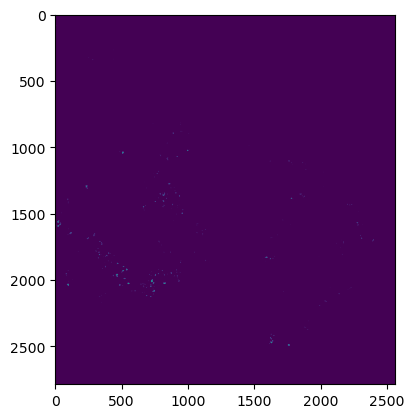

In [6]:
trans2csv(hsp_img_path+hsp_img_name,shp_file_path+shp_file_name,'../data/buso_gt_2307.csv','../data/gs_2307_mnf_m1')

In [4]:
name='../data/gs_2307_sub_m1.csv'

In [5]:
df = pd.read_csv(name)

## Index 생성

In [41]:
df['location']=[i for i in range(1,len(df)+1)]
df['location'].to_csv(f'../data/gs_2307_mnf_index.csv',index=False)
df['Sum'] = df.iloc[:, :150].sum(axis=1)
df = df[df['Sum'] != 0]
df=df.drop('Sum',axis=1)
df['location'].to_csv(f'../data/gs_2307_remove_mnf_index.csv',index=False)

KeyboardInterrupt: 

In [10]:
print(len(df))

3817874


## 영상이 사각형이 아닌 경우 빈 공간 삭제

In [6]:
def remove_zero(name1,name2):
    df1= pd.read_csv(name1)
    # df2= pd.read_csv("../data/buso_2307_remove_index.csv")
    print(len(df1))
    # filtered_df = df1.loc[df2['location']]
    df1['Sum'] = df1.iloc[:, :150].sum(axis=1)
    df1 = df1[df1['Sum'] != 0]
    df1=df1.drop('Sum',axis=1)
    print(len(df1))
    df1.to_csv(name2,index=False)

In [42]:
remove_zero(name,'../data/remove_gs_2307_mnf_m1.csv')

7126588
2897277


In [ ]:
for i in range(1,7):
    name1= f'../data/buso_2307_sub_m{i}.csv'
    df1= pd.read_csv(name1)
    df1['Sum'] = df1.iloc[:, :150].sum(axis=1)
    df1 = df1[df1['Sum'] != 0]
    df1=df1.drop('Sum',axis=1)
    print(len(df1))
    df1.to_csv(f'../data/remove_buso_2307_sub_m{i}.csv',index=False)

## M2

In [19]:
def create_temporal_feature(dataframe,name):
    for i in range(0, 150, 10):
        cols_to_average = dataframe.iloc[:, i:i+10]
        dataframe[f'average_{i//10 + 1}'] = cols_to_average.mean(axis=1)
    dataframe.to_csv(f'{name[:-7]}_m2.csv',index=False)

In [21]:
df = pd.read_csv(name)
create_temporal_feature(df,name)

## M3

In [9]:
def create_spatial_feature1(dataframe,name,row,col):
    tmp =np.array(dataframe).reshape(row,col,151)
    rows = len(tmp)
    cols = len(tmp[0])
    result = np.zeros((rows,cols,150))
    for i in tqdm(range(rows)):
        for j in range(cols):
            for b in range(150):
                sum=0
                cnt=0
                if i == 0:
                    dx=[0,1]
                elif i == rows-1:
                    dx=[-1,0]
                else:
                    dx=[-1,0,1]
                if j == 0:
                    dy=[0,1]
                elif j == cols-1:
                    dy=[-1,0]
                else:
                    dy=[-1,0,1]
                for k in dx:
                    for l in dy:
                        if k == 0 and l == 0:
                            continue
                        sum += tmp[i+k,j+l,b]
                        cnt+=1
                result[i,j,b] = sum/cnt
    result = pd.DataFrame(result.reshape(row*col,150),columns=[f'nx{i}'for i in range(1,151)])
    result= pd.concat([dataframe,result],axis=1)
    
    result.to_csv(f'{name[:-7]}_m3.csv',index=False)
                

In [11]:
df = pd.read_csv(name)
create_spatial_feature1(df,name,2715, 1843)

100%|██████████| 2715/2715 [24:19<00:00,  1.86it/s]


## M4

In [6]:
def combine(dataframe1,dataframe2,name):
    #dataframe1: m2
    #dataframe2: m3
    new_dataframe = pd.concat([dataframe1,dataframe2[151:-1]],axis=1)
    new_dataframe.to_csv(f'{name[:-7]}_m4.csv',index=False)

In [7]:
df1= pd.read_csv('../data/gs_2308_m2.csv')
df2= pd.read_csv('../data/gs_2308_m3.csv')
name1='../data/gs_2308_m1.csv'
combine(df1,df2,name1)

## spatial_temporal_interaction_feature

In [24]:
def create_sti_feature(dataframe,name):
    for i in range(166, 306, 10):
        cols_to_average = dataframe.iloc[:, i:i+10]
        dataframe[f'average_{i//10 + 1}'] = cols_to_average.mean(axis=1)
    dataframe.to_csv(f'{name[:-7]}_m5.csv',index=False)

In [13]:
df

,band 1,band 2,band 3,band 4,band 5,band 6,band 7,band 8,band 9,band 10,...,band 142,band 143,band 144,band 145,band 146,band 147,band 148,band 149,band 150,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12365995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12365996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12365997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12365998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
create_sti_feature(df,name)

## M6

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def get_neighbor_indices(i, rows, j, cols, window_size):
    """
    지정된 window_size에 따라 이웃 픽셀의 인덱스 범위를 반환하는 함수
    """
    # window_size는 항상 홀수라고 가정 (3, 5, 7, ...)
    half_size = window_size // 2
    
    # 각 축(x, y)에 대한 시작과 끝 인덱스 계산
    start_x = max(0, i - half_size)
    end_x = min(rows - 1, i + half_size)
    
    start_y = max(0, j - half_size)
    end_y = min(cols - 1, j + half_size)
    
    # 현재 위치(i, j)를 기준으로 상대적인 인덱스(dx, dy) 생성
    dx = list(range(start_x - i, end_x - i + 1))
    dy = list(range(start_y - j, end_y - j + 1))
    
    return dx, dy

def calculate_neighbor_average(tmp, i, j, b, dx, dy):
    """이웃 픽셀들의 평균값을 계산하는 함수"""
    values = []
    for k in dx:
        for l in dy:
            # 자기 자신은 계산에서 제외
            if k == 0 and l == 0:
                continue
            values.append(tmp[i + k, j + l, b])
    
    # 이웃이 없는 경우(자기 자신만 있는 경우) 0을 반환하여 오류 방지
    if not values:
        return 0
    return np.mean(values)

def create_spatial_feature(dataframe, name, row, col, window_size=5):
    """
    지정된 window_size에 따라 공간적 특성을 계산하여 새로운 특성을 생성하는 함수
    """
    # 3차원 배열로 변환
    # 마지막 'target' 컬럼을 제외하기 위해 150개 채널로 가정
    num_features = dataframe.shape[1] -1 if 'target' in dataframe.columns else dataframe.shape[1]
    tmp = np.array(dataframe.iloc[:, :num_features]).reshape(row, col, num_features)
    rows, cols, bands = tmp.shape
    
    result = np.zeros((rows, cols, bands))
    
    # 각 픽셀에 대해 이웃 픽셀들의 평균 계산
    for i in tqdm(range(rows), desc=f"Processing {window_size}x{window_size} window"):
        for j in range(cols):
            # 일반화된 함수 호출
            dx, dy = get_neighbor_indices(i, rows, j, cols, window_size)
            for b in range(bands):
                result[i, j, b] = calculate_neighbor_average(tmp, i, j, b, dx, dy)
                
    # 결과를 데이터프레임으로 변환
    result_df = pd.DataFrame(
        result.reshape(row * col, bands),
        columns=[f'm{window_size}x{i+1}' for i in range(bands)]
    )
    
    # 원본 데이터프레임과 결합
    final_result = pd.concat([dataframe.reset_index(drop=True), result_df], axis=1)
    
    # 결과 저장 (파일명에 window_size 반영)
    output_filename = f'{name.split(".")[0]}_m{window_size}.csv'
    final_result.to_csv(output_filename, index=False)
    print(f"결과가 {output_filename} 파일로 저장되었습니다.")

In [15]:
create_spatial_feature2(df,name,2715, 1843)

100%|██████████| 2715/2715 [1:01:51<00:00,  1.37s/it]


In [11]:
for i in range(6,11,4):
    name = f'../data/sample{i}_m4.csv'
    dataframe= pd.read_csv(name)
    create_sti_feature(dataframe,name)

## 해상도 조절

In [ ]:
import numpy as np
from skimage.transform import resize
import os

try:
    import rasterio
except ImportError:
    print("'rasterio' 라이브러리가 필요합니다. 'pip install rasterio' 명령어로 설치해주세요.")
    exit()

# --- 1. 원본 데이터 준비 ---
# 실제 파일 경로를 여기에 입력하세요.
original_data_path = r"E:\문화재\영상 데이터\2023\hyper\03_20230703_Gongsan_Hyper_Subset"
# original_data_path = 'sample_raster_data.tif' 

try:
    # 샘플 데이터 생성 (실제 사용 시 이 'if' 블록은 필요 없음)
    if not os.path.exists(original_data_path):
        print(f"샘플 원본 데이터 '{original_data_path}'를 생성합니다.")
        # Rasterio는 (밴드, 높이, 너비) 순서로 데이터를 다룹니다.
        sample_array = np.random.rand(150, 400, 400).astype(np.float32)
        with rasterio.open(
            original_data_path,
            'w',
            driver='GTiff',
            height=sample_array.shape[1],
            width=sample_array.shape[2],
            count=sample_array.shape[0],
            dtype=sample_array.dtype,
        ) as dst:
            dst.write(sample_array)

    # Rasterio를 사용해 데이터 불러오기
    with rasterio.open(original_data_path) as src:
        # 데이터를 (밴드, 높이, 너비) 순서로 읽음
        data_from_raster = src.read()
        # 축 순서를 (높이, 너비, 밴드)로 변경
        hyper_image_array = data_from_raster.transpose((1, 2, 0))
    
    print(f"Rasterio 데이터 로드 완료: {original_data_path} (형태: {hyper_image_array.shape})")
    print("-" * 30)

except Exception as e:
    print(f"데이터 로드 중 오류 발생: {e}")
    exit()

# --- 2. 설정 ---
downsampling_factors = [2, 4, 8]
interpolation_order = 3

# --- 3. 처리 및 저장 ---
for factor in downsampling_factors:
    print(f"{factor}배 다운샘플링 처리 및 저장 시작...")

    # 새로운 데이터 형태(shape) 계산
    new_height = hyper_image_array.shape[0] // factor
    new_width = hyper_image_array.shape[1] // factor
    new_shape = (new_height, new_width, hyper_image_array.shape[2])

    # scikit-image로 해상도 저하
    downsampled_array = resize(
        hyper_image_array,
        output_shape=new_shape,
        order=interpolation_order,
        preserve_range=True,
        anti_aliasing=True
    ).astype(hyper_image_array.dtype)

    # (선택) 처리된 파일을 다시 GeoTIFF 형식으로 저장
    # c, h, w 순서로 다시 변경 필요
    output_tiff_array = downsampled_array.transpose((2, 0, 1))
    output_tiff_filename = original_data_path+factor
    with rasterio.open(
        output_tiff_filename,
        'w',
        driver='GTiff',
        height=output_tiff_array.shape[1],
        width=output_tiff_array.shape[2],
        count=output_tiff_array.shape[0],
        dtype=output_tiff_array.dtype,
    ) as dst:
        dst.write(output_tiff_array)
    print(f"-> GeoTIFF 저장 완료: '{output_tiff_filename}'")


print("-" * 30)
print("모든 작업이 완료되었습니다.")

Rasterio 데이터 로드 완료: E:\문화재\영상 데이터\2023\hyper\03_20230703_Gongsan_Hyper_Subset (형태: (2799, 2563, 150))
------------------------------
2배 다운샘플링 처리 및 저장 시작...


c:\Users\jmt30\anaconda3\envs\gs\Lib\site-packages\rasterio\__init__.py:327: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


-> GeoTIFF 저장 완료: 'processed_hyper_x2'
4배 다운샘플링 처리 및 저장 시작...
-> GeoTIFF 저장 완료: 'processed_hyper_x4'
8배 다운샘플링 처리 및 저장 시작...
-> GeoTIFF 저장 완료: 'processed_hyper_x8'
------------------------------
모든 작업이 완료되었습니다.
